## Minimum Variance Portfolio Backtest.

In [1]:
from __future__ import annotations


from imitation.algorithms.adversarial.airl import AIRL
from stable_baselines3 import SAC

from qamsi.cov_estimators.rl.inverse_rl.irl_estimator import IRLCovEstimator

from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from run import Dataset, initialize

In [2]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

ESTIMATOR = IRLCovEstimator(
    shrinkage_type="linear",
    imitation_trainer_cls=AIRL,
    policy_builder=lambda env: SAC("MlpPolicy", env, verbose=0, device="mps"),
    dataset=DATASET,
    trading_config=trading_config,
    rebal_freq=REBAL_FREQ,
    topn=TOP_N,
    save_path=None,
    window_size=None,
    use_saved_policy=False,
    random_seed=12,
)

In [3]:
preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [4]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.968    |
|    disc/disc_acc_expert             | 0.938    |
|    disc/disc_acc_gen                | 0.998    |
|    disc/disc_entropy                | 0.0864   |
|    disc/disc_loss                   | 0.105    |
|    disc/disc_proportion_expert_pred | 0.47     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 4.78e+03 |
|    disc/n_expert                    | 50       |
|    disc/n_generated                 | 50       |
|    gen/rollout/ep_rew_wrapped_mean  | -1.98    |
|    gen/train/actor_loss             | 0.109    |
|    gen/train/critic_loss            | 7.4      |
|    gen/train/ent_coef               | 0.426    |
|    gen/train/ent_coef_loss          | -0.0465  |
|    gen/train/learning_rate          | 0.0003   |
|    gen/train/n_updates              | 4.68e+03 |
-------------------------------


Computing Weights: 100%|██████████| 283/283 [19:34<00:00,  4.15s/it]   


StrategyStatistics:
* final_nav = 11.207364
* geom_avg_total_r = 0.135533
* geom_avg_xs_r = 0.116236
* std_xs_r = 0.147926
* min_xs_r = -0.080193
* max_xs_r = 0.101960
* skew = 0.111410
* kurtosis = 14.082940
* max_dd = -0.279310
* sharpe = 0.785774
* alpha_buy_hold = 0.057961
* tracking_error_buy_hold = 0.143295
* ir_buy_hold = 0.404491
* factor_loadings = {'low_risk': 0.5585700517013177, 'momentum': -0.07408212936707034, 'quality': 0.13554761745818625, 'size': 0.057632069481273314, 'value': -0.21586415172550233, 'spx': 0.7429932965182071}
* alpha_benchmark = 0.053621
* alpha_benchmark_pvalue = 0.006874
* tracking_error_benchmark = 0.083305
* ir_benchmark = 0.643673
* ttest_pval = 0.251342
* levene_pval = 0.000000
* timing_ability_coef = -0.019705
* timing_ability_pval = 0.210188

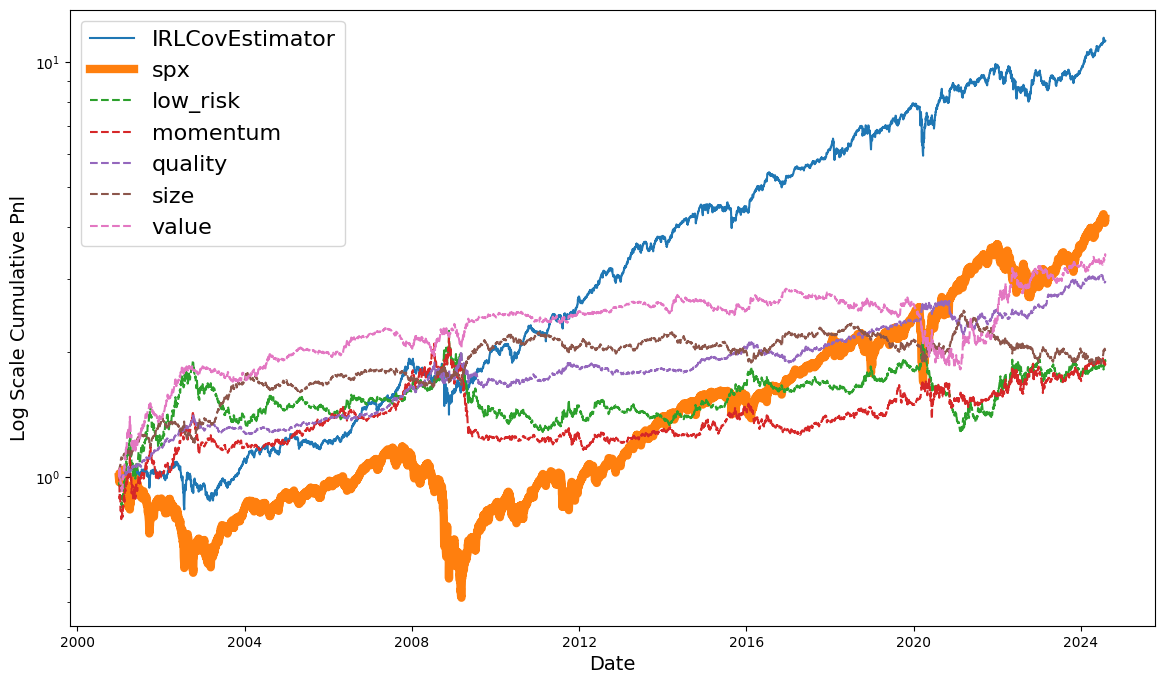

In [5]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

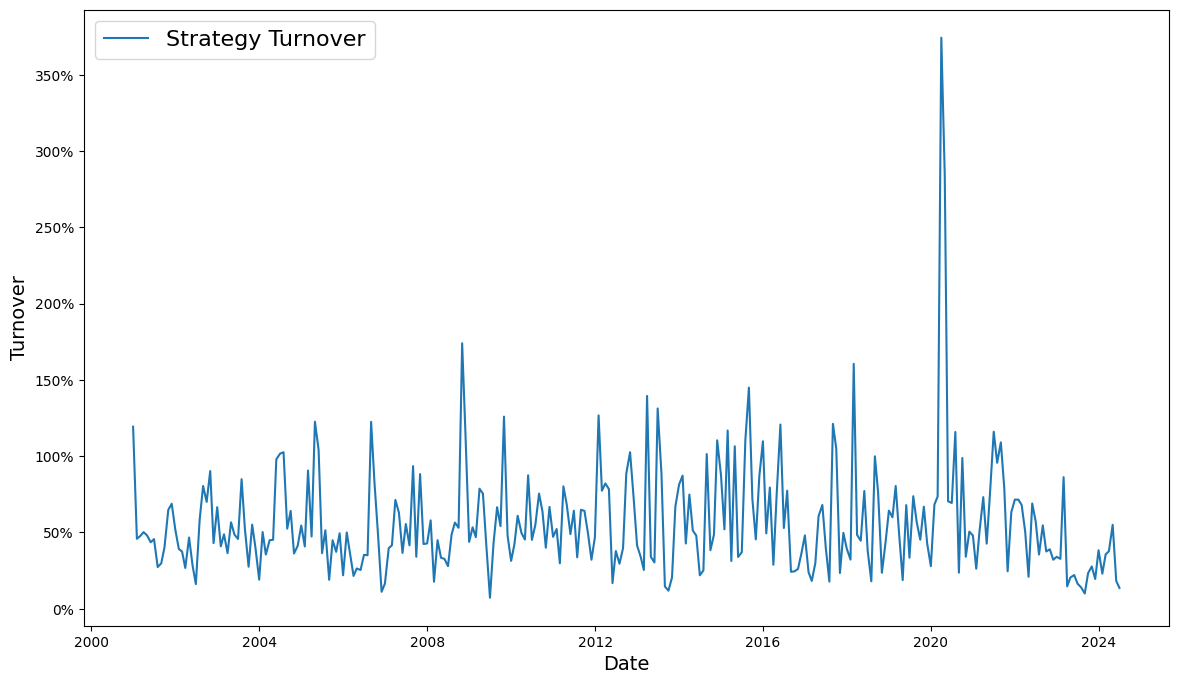

In [6]:
runner.plot_turnover()

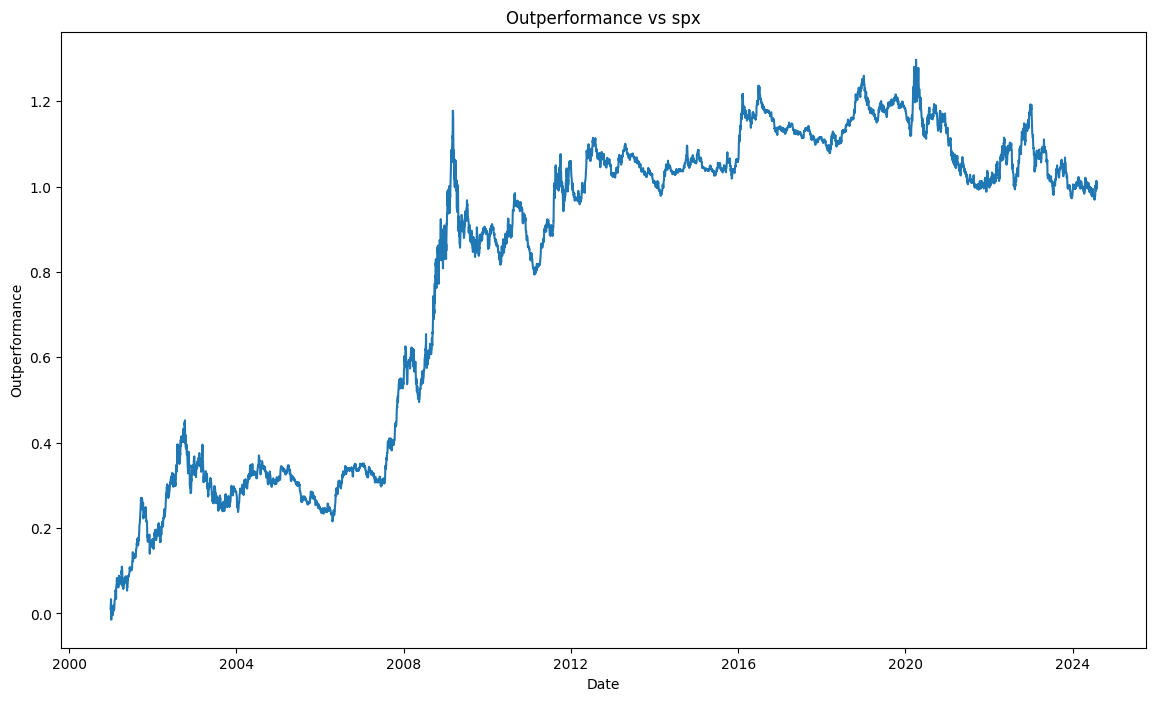

In [7]:
runner.plot_outperformance(mkt_only=True)

In [8]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")